# Basic approximate bayesian computation on the RISC model

The RISC model simulates changes in Scottish cattle farms over time. In the model, each year every farm owner makes a decision that will affect the number of cattle and, therefore, the size of the farm. There are 4 different factors that may affect their decision. These are:
- Succession: Whether or not the owner has a successor.
- Leisure: Whether farming is considered as a secondary (rather than primary) source of income.
- Diversification: Whether the farm is considered for diversification into tourism.
- Industrialisation: Whether a professional manager could be employed to help with an increased farm size.

In the model, each of these four factors may be on (affecting decision making) or off (not considered). Given there are four factors that must be in one of two states, there are a total of 16 possible sets of parameters (numbered 0 to 15).

The model has three outputs, each of which is time series data representing the number of *small*, *medium* and *large* farms over a period of 13 years. 

Previous to this notebook, I ran history matching on each of the 16 possible models, and found that models 12-15 are plausible (matching the results in Jiaqi's paper). Next, we perform some basic approximate bayesian computation on these four remaining models.

We want to test the probability that each of the four remaining models can recreate the empirical data. To do this, we run each model 30 times. For each run, we measure the error of each output (no. of small, medium and large farms) by calculating the mean absolute scaled error (MASE) against the empirical data. If this error is less than or equal to a given threshold (for each output) then we accept the simulation. If the error is greater than the threshold (for any output) we reject it. We use the total number of acceptances (out of our 30 runs) to derive the probability that the given set of parameters is suitable.

How we decide what this threshold should be is subjective. Initially, we'll set the threshold to be equal to our uncertainties about the model. We take two factors into account when calculating uncertainty:
1. The ensemble variance --- that is, how much the outputs vary each time the model is run. To measure this, we calculate the variance between an ensemble of 25 runs. We measure the variance separately for each output.
2. The model discrepancy --- the error of the output, measured as the MASE between the output and empirical data.
We average the ensemble variance and model discrepancy over the four models we are testing and use the sum of these two measures as our quantified uncertainty about the models. This will be our error threshold.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import helper

# number of ensembles run with results saved
k = 100

# indexes of the plausible models found in history matching
plaus_space = [12, 13, 14, 15]

# each output has an individually measured uncertainty
uncert = {'n small': 1.48, 'n medium': 2.167, 'n large': 5.373} 

posteriors = dict((x, 0) for x in plaus_space)
# each possible set of factors is referred to as a "driver"
for driver_i in plaus_space:
    driver = helper.drivers[driver_i]
    for i in range(k):
        # the simulations have been prerun and saved to csv
        df = pd.read_csv(helper.get_fp(driver, i+100))
        passed = True  # assume passed until proven otherwise
        for output in helper.OUTPUTS:
            obs = helper.observations[output].tolist()
            est = df[output].tolist()
            d = helper.error_func(obs, est)  # compute distance
            # if one output fails to pass, the whole simulation has failed
            if d > uncert[output]:
                passed = False
                break
        if passed:
            posteriors[driver_i] += 1
print(posteriors)

{12: 1, 13: 0, 14: 0, 15: 0}


Only one run of model 12 passed (out of 30 runs), and all runs of modesl 13, 14 and 15 failed. This suggests the uncertainties we have calculated are too small of a threshold.

**If the threshold was slightly higher, would more runs pass?**
Next, we'll test the effects of using different thresholds by perturbing the originals. We'll change the threshold to be between -0.15 and +3 of the original (remember, each model output has a separate threshold).

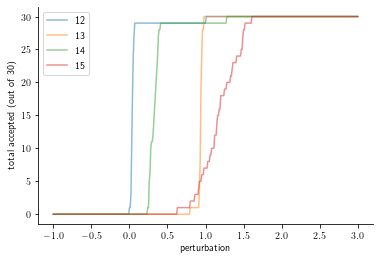

In [2]:
def test_thresholds(plaus_space, perturbator):
    start_found = []
    end_found = []
    start_end = dict((ps, []) for ps in plaus_space)
    Y = dict((ps, []) for ps in plaus_space)
    for driver_i in plaus_space:
        errors = dict((output, []) for output in helper.OUTPUTS)
        driver = helper.drivers[driver_i]
        for i in range(k):
            df = pd.read_csv(helper.get_fp(driver, i+100)
            for output in helper.OUTPUTS:
                obs = helper.observations[output].tolist()
                est = df[output].tolist()
                d = helper.error_func(obs, est)  # compute distance
                errors[output].append(d)
        for perturb in perturbator:
            total_passed = 0
            for run in range(k):
                passed = True
                for output in helper.OUTPUTS:
                    if errors[output][run] > (uncert[output]  + perturb):
                        passed = False
                if passed:
                    total_passed += 1
            Y[driver_i].append(total_passed)
            if driver_i not in start_found and total_passed > 0:
                start_found.append(driver_i)
                start_end[driver_i].append(perturb)
            if driver_i not in end_found and total_passed == k:
                end_found.append(driver_i)
                start_end[driver_i].append(perturb)
    return Y, start_end

plaus_space = (12, 13, 14, 15)
perturbator = np.linspace(-1, 3, 401)
Y, start_end = test_thresholds(plaus_space, perturbator)
for ps in plaus_space:
    plt.plot(list(perturbator), Y[ps], label=str(ps), alpha=0.5)
plt.xlabel('perturbation')
plt.ylabel('total accepted (out of %d)' % k)
plt.legend()
plt.show()

Model 12 only needs the smallest increase in threshold to accept all models. Model 14 needs and increase of approximately 0.25.

Models 13 and 15 need a much higher increase in threshold (by almost 1.0) to start accepting models. All runs of model 13 are suddenly accepted above a given threshold, where as for 15 it is a more gradual acceptance compared.


**How significant is the difference between models 12 & 14 compared against models 13 & 15? There is a visual difference with 13 and 15 requiring a large threshold, but how do we determine if this is significant, and what is a good choice for a threshold?**

Our history matching (done prior to this notebook) reduced our initial 16 plausible parameter sets to just 4 (referred to as models 12-15). We next investigate how these 4 differ from the 12 that were rejected.

The 12 models that were rejected were excluded because their error (difference between simulation results and empirical data) was too large. We'd like to know how much larger is the error of these 12 rejected models compared to the 4 we kept? To put it another way, how much would we need to increase our error threshold to keep these 12 models?

We investigate perturbing the threshold in the range [-0.15, 50].

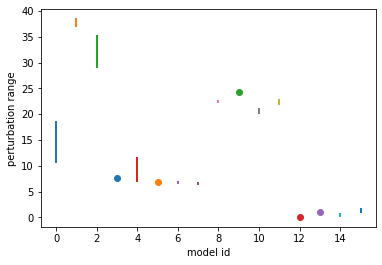

In [3]:
k = 10
Y, start_end = test_thresholds(range(16), np.linspace(-0.15, 50, 200))
for ps in start_end.keys():
    if start_end[ps][0] != start_end[ps][1]:
        plt.plot([ps, ps], start_end[ps], linewidth=2)
    else:
        plt.scatter((ps,), (start_end[ps][0],))
plt.xlabel('model id')
plt.ylabel('perturbation range')
plt.show()

The above figure shows how much the error threshold needs to be increased to accept each models. The x axis indicates the ID of the model. Each model has a vertical line (or dot) associated with it.
For a line, the bottom of the line indicates the smallest increase in the threshold required to accept some (but not all) simulation runs (i.e. the bottom of the slope in the previous figure).
The top of the line indicates the threshold increase required to accept all given simulation runs (i.e. the top of the slope).
A dot indicates there is no gradual increase (i.e. there is no threshold for which only some simulation runs were accepted) and instead all runs were rejected below this point and all were accepted above this point.

## Discussion
The results in the figure above show that the 16 models can be grouped into four clusters based on the size of their error when compared with the observational data.

The group with the lowest error contains models 12--15. These have the common features that both succession and leisure are switched on (i.e. they form part of the farm owner's decision making). The other two factors (diversification and industrialisation) are mixed within this group. This suggests that the availability of a successor and the prospect of using farming as a secondary source of income (leisure) are important factors when making decisions on the size of a cattle farm.

Models 0--8 all have the common feature that succession is switched off. Within these, models 0 and 3--7 form a cluster. However, models 1 and 2 stand out as being much worse. These two have the common features that succession and leisure are not used but industralisation is considered. These suggests that considering industrialisation without leisure leads to a large error. Otherwise, no other combination of drivers that don't feature succession show any significant changes in ability to model the observed data.

The final group contains models 8--11. These have the common features that succession is switched on and leisure is off. The other two factors are mixed. The high error in this group suggests that if succession is a factor in decision making then it is important to also consider leisure.

These results show that succession and leisure are the main factors for predicting farming trends, and these two factors must both be switched on to accurately model real world trends. Additionally, if industrialisation is used as part of decision making, then leisure must also be considered. Diversification did not appear to have any effect on the model results (that is, if succession, leisure and industrialisation are fixed, the results do not change as a result of setting diversification to be switched on or off). This suggests that while diversification may be part of some farm holders' decision making, it is not useful for prediting farming trends as a whole, and are therefore unlikely to be used by the majority of farmers.

The figure below highlights which factors are switched on/off for which models; black indicates off, green indicates on.

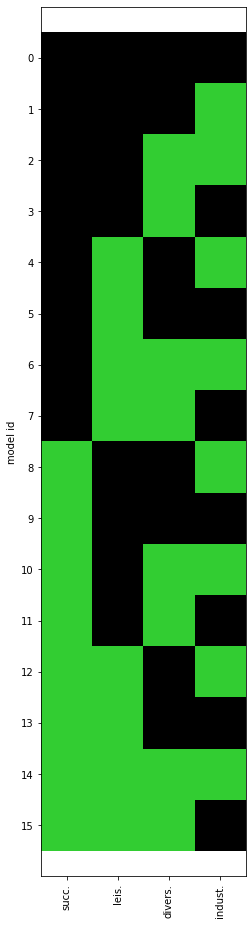

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np

import helper

fig, ax = plt.subplots(figsize=(4, 16))
Z = [[int(d) for d in driver] for driver in helper.drivers]
nodes = [0, 0.5, 0.5, 1]
colors = ['black', 'black', 'limegreen', 'limegreen']
cmap = LinearSegmentedColormap.from_list("", list(zip(nodes, colors)))
im = plt.imshow(Z, cmap=cmap)
plt.yticks(range(16))
a, b = plt.xlim()
plt.xticks(np.linspace(a+0.5, b-0.5, 4), ('succ.', 'leis.', 'divers.', 'indust.'))
plt.xticks(rotation=90)
# fix for mpl bug that cuts off top/bottom of plot
b, t = plt.ylim() 
ax.set_ylabel('model id')
plt.ylim(b+0.5, t-0.5)
plt.show()

Below shows figure 2 separately for each output. That is, it shows what the threshold would need to be for each output of each model to be accepted.
Each column represents one of the three outputs (number of small, medium or large farms).
Each row represents one of the models (from 0--15).
For convenience, the models are coloured to highlight the four clusters that were found in figure 2.

In the clusters containing the models that performed the worst (models 1--2 and models 8-11 in red), it is their inability to predict the trend of large farms that makes them stand out. They are also worse than the green cluster in predicting small and medium farms, but not as considerably so.

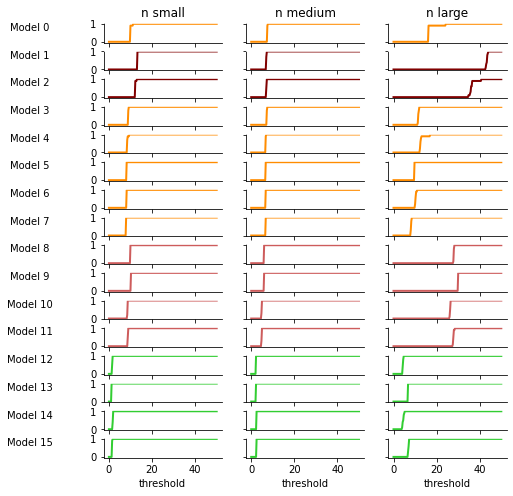

In [5]:
import analyse_post_separate_outputs